In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/AI_Project/data/'

Mounted at /content/drive


In [ ]:
%%capture
!pip install pykeen

In [ ]:
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from typing import List
import pykeen.typing
from pykeen import predict

from pykeen.datasets import DBpedia50
from pykeen.datasets import DB100K
from pykeen.datasets import FB15k

import torch
import pandas as pd
import os
from tqdm import tqdm

INFO:pykeen.utils:Using opt_einsum


# First Steps (PyKeen Doc)

In [ ]:
model_dir = data_dir+'DBpedia50_transe/'

if os.path.exists(model_dir):        
    model = torch.load(model_dir+'trained_model.pkl')
else:
    pipeline_result = pipeline(
        dataset='DBpedia50',
        model='TransE',
        random_seed=42,
        evaluator='RankBasedEvaluator',
        result_tracker='tensorboard'
    )
    pipeline_result.save_to_directory(model_dir)
    model = pipeline_result.model

In [ ]:
triples_factory = DBpedia50().training
# Get tensor of entity identifiers
# entity_ids = torch.as_tensor(triples_factory.entities_to_ids(["Barack Obama"]))

In [ ]:
entity_representation_modules: List['pykeen.nn.Representation'] = model.entity_representations
relation_representation_modules: List['pykeen.nn.Representation'] = model.relation_representations


entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
relation_embedding_tensor: torch.FloatTensor = relation_embeddings()

entity_embedding_tensor: torch.FloatTensor = entity_embeddings(indices=None)
relation_embedding_tensor: torch.FloatTensor = relation_embeddings(indices=None)

entity_embedding_tensor = model.entity_representations[0](indices=None).detach().numpy()
relation_embedding_tensor = model.relation_representations[0](indices=None).detach().numpy()

In [ ]:
# print("Entities: ", entity_embedding_tensor.shape)
# print("Relations: ", relation_embedding_tensor.shape)

Entities:  (24624, 50)
Relations:  (351, 50)


In [ ]:
# List of entities - relations - triples

# triples_factory.entity_to_id
# triples_factory.relation_to_id
triples_factory.triples

array([['$_(film)', 'starring', 'Goldie_Hawn'],
       ['&ME', 'language', 'English_language'],
       ["'Cause_I'm_a_Man", 'recordedIn', 'Fremantle'],
       ...,
       ['Șimon_River', 'rightTributary', 'Tisa_River_(Șimon)'],
       ['Ținutul_Dunării', 'isPartOf', 'Dobruja'],
       ['ʻAkohekohe', 'order', 'Passerida']], dtype='<U95')

# Using a DataFrame (Lab Implementation)

In [ ]:
triples_path = data_dir+"triples.csv"

if os.path.exists(triples_path):
    triples_df = pd.read_csv(triples_path)
else:
    triples_df = pd.DataFrame([], columns=["head", "relation", "tail"])
    triples = triples_factory.triples

    for i in tqdm(range(len(triples))):
        triple = triples[i]
        triples_df.loc[i] = [triple[0], triple[1], triple[2]]

    triples_df.to_csv(triples_path, index=False)

triples_df.head()

,head,relation,tail
0,$_(film),starring,Goldie_Hawn
1,&ME,language,English_language
2,'Cause_I'm_a_Man,recordedIn,Fremantle
3,(Ain't_Nobody_Loves_You)_Like_I_Do,genre,Dance_music
4,(Ain't_Nobody_Loves_You)_Like_I_Do,recordLabel,RCA_Records


## Metrics Evaluation

In [ ]:
training_labels = TriplesFactory.from_labeled_triples(
  triples_df[["head", "relation", "tail"]].values,
  create_inverse_triples=False,
  entity_to_id=None,
  relation_to_id=None,
  compact_id=True,
  filter_out_candidate_inverse_relations=True,
  metadata=None,
)

testing_labels = TriplesFactory.from_labeled_triples(
  triples_df[["head", "relation", "tail"]].values,
  create_inverse_triples=False,
  entity_to_id=training_labels.entity_to_id,
  relation_to_id=training_labels.relation_to_id,
  compact_id=True,
  filter_out_candidate_inverse_relations=True,
  metadata=None,
)

In [ ]:
pipeline_result_transe = pipeline(
    training=training_labels,
    testing=testing_labels,
    #dataset='Countries',
    model='TransE',
    model_kwargs=dict(embedding_dim=80),
    random_seed=256,
    optimizer = torch.optim.Adam,
    optimizer_kwargs=dict(lr=1.0e-02),
    training_kwargs=dict(num_epochs=10),
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/32.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.11s seconds


In [ ]:
def print_metrics(pipeline_result):
  print(pipeline_result.training)
  print()
  print('hits@10', pipeline_result.get_metric('hits@10'))
  print('mr', pipeline_result.get_metric('mr'))
  print('mrr', pipeline_result.get_metric('mrr'))
  print()
  pipeline_result.plot_losses()

TriplesFactory(num_entities=24624, num_relations=351, create_inverse_triples=False, num_triples=32203)

hits@10 0.21799211253609913
mr 1135.5113525390625
mrr 0.11642783093044515



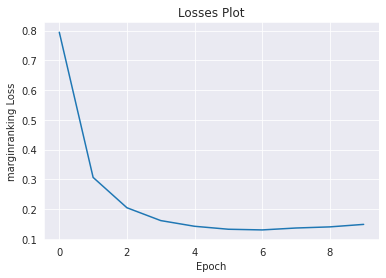

In [ ]:
print_metrics(pipeline_result_transe)

## Prediction

In [ ]:
# predict.get_prediction_df(
#     model=pipeline_result_transe.model, head_label="italy", relation_label="locatedin", triples_factory=pipeline_result_transe.training,
# )

res = predict.predict_target(model=pipeline_result_transe.model, head="&ME", relation="language", triples_factory=pipeline_result_transe.training).df
# res.index[res['tail_label'] == "English_language"]
res.head()

,tail_id,score,tail_label
1887,1887,-11.233741,Armenian_language
14980,14980,-11.454445,Murtaza_Rakhimov
3912,3912,-11.521836,Cataulacus
6630,6630,-11.626891,English_language
11816,11816,-11.704875,Kenareh_Rural_District


# PyKeen Datasets

## DBPedia50

In [ ]:
pipeline_result_transe_dbpedia = pipeline(
    #training=training_labels,
    #testing=testing_labels,
    dataset='DBPedia50',
    model='TransE',
    model_kwargs=dict(embedding_dim=80),
    random_seed=256,
    optimizer = torch.optim.Adam,
    optimizer_kwargs=dict(lr=1.0e-02),
    training_kwargs=dict(num_epochs=100),
)

#pipeline_result.save_to_directory('countries_transe')

INFO:pykeen.datasets.utils:Caching preprocessed dataset to file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=24624, num_relations=351, create_inverse_triples=False, num_triples=32203, path="/root/.data/pykeen/datasets/dbpedia50/train.txt") to file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.datasets.base:Stored training factory to file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=24624, num_relations=351, create_inverse_triples=False, num_triples=2095, path="/root/.data/pykeen/datasets/dbpedia50/test.txt") to file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.datasets.base:Stored testing factory to file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_T

Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.72s seconds


TriplesFactory(num_entities=24624, num_relations=351, create_inverse_triples=False, num_triples=32203, path="/root/.data/pykeen/datasets/dbpedia50/train.txt")

hits@10 0.04892601431980907
mr 3701.7197265625
mrr 0.026981375610060223



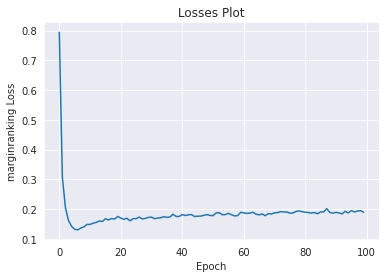

In [ ]:
print_metrics(pipeline_result_transe_dbpedia)

## Wikidata5M

In [ ]:
pipeline_result_transe_wikidata = pipeline(
    #training=training_labels,
    #testing=testing_labels,
    dataset='Wikidata5M',
    model='TransE',
    model_kwargs=dict(embedding_dim=80),
    random_seed=256,
    optimizer = torch.optim.Adam,
    optimizer_kwargs=dict(lr=1.0e-02),
    training_kwargs=dict(num_epochs=10),
)

#pipeline_result.save_to_directory('countries_transe')

INFO:pykeen.datasets.utils:Caching preprocessed dataset to file:///root/.data/pykeen/datasets/wikidata5m/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.datasets.base:Requesting dataset from https://zenodo.org/record/5546383/files/wikidata5m_transductive.tar.gz
INFO:pykeen.datasets.base:Extracted to /root/.data/pykeen/datasets/wikidata5m.
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594149, num_relations=822, create_inverse_triples=False, num_triples=20614279, path="/root/.data/pykeen/datasets/wikidata5m/wikidata5m_transductive_train.txt") to file:///root/.data/pykeen/datasets/wikidata5m/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.datasets.base:Stored training factory to file:///root/.data/pykeen/datasets/wikidata5m/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594149, num_relations=822, create_inverse_triples=False, num_triples=4977, path="/root/.data/pykeen/datasets

Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/80525 [00:00<?, ?batch/s]

KeyboardInterrupt: ignored

In [ ]:
pipeline_result_transe_wikidata.save_to_directory(data_dir+'wikidata_transe')

In [ ]:
print_metrics(pipeline_result_transe_wikidata)

# Beyond the Pipeline (PyKeen Doc) [Da Scartare]

In [ ]:
from pykeen.models import TransE
from torch.optim import Adam
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation import RankBasedEvaluator

In [ ]:
dataset = DBpedia50()
training_triples_factory = dataset.training

In [ ]:

# Pick a Model
model = TransE(triples_factory=training_triples_factory,
               random_seed=42)

# Pick an optimizer from Torch
optimizer = Adam(params=model.get_grad_params())

# Pick a training approach (sLCWA or LCWA)
training_loop = SLCWATrainingLoop(
    model=model,
    triples_factory=training_triples_factory,
    optimizer=optimizer,
)

In [ ]:
# Train
_ = training_loop.train(
    triples_factory=training_triples_factory,
    num_epochs=5,
    batch_size=256,
)

In [ ]:
# Pick an evaluator
evaluator = RankBasedEvaluator()

# Get triples to test
mapped_triples = dataset.testing.mapped_triples

In [ ]:
# Evaluate
results = evaluator.evaluate(
    model=model,
    mapped_triples=mapped_triples,
    batch_size=1024,
    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ],
)
print(results)

Evaluating on cpu:   0%|          | 0.00/2.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 47.81s seconds


In [ ]:
results.metrics

{'z_hits_at_k': pykeen.metrics.ranking.ZHitsAtK,
 'inverse_arithmetic_mean_rank': pykeen.metrics.ranking.InverseArithmeticMeanRank,
 'variance': pykeen.metrics.ranking.Variance,
 'geometric_mean_rank': pykeen.metrics.ranking.GeometricMeanRank,
 'z_inverse_harmonic_mean_rank': pykeen.metrics.ranking.ZInverseHarmonicMeanRank,
 'inverse_median_rank': pykeen.metrics.ranking.InverseMedianRank,
 'harmonic_mean_rank': pykeen.metrics.ranking.HarmonicMeanRank,
 'arithmetic_mean_rank': pykeen.metrics.ranking.ArithmeticMeanRank,
 'inverse_harmonic_mean_rank': pykeen.metrics.ranking.InverseHarmonicMeanRank,
 'adjusted_hits_at_k': pykeen.metrics.ranking.AdjustedHitsAtK,
 'median_rank': pykeen.metrics.ranking.MedianRank,
 'adjusted_geometric_mean_rank_index': pykeen.metrics.ranking.AdjustedGeometricMeanRankIndex,
 'adjusted_arithmetic_mean_rank_index': pykeen.metrics.ranking.AdjustedArithmeticMeanRankIndex,
 'count': pykeen.metrics.ranking.Count,
 'z_geometric_mean_rank': pykeen.metrics.ranking.ZGeo